In [1]:
%matplotlib inline

import os 
import sys 
import time
import hashlib

from datetime import datetime 

import numpy as np  # learn 
import pandas as pd # learn
from pandas import *
from numpy import *

from scipy import stats # look at scipy
from scipy import linalg
from scipy import *

 
import matplotlib as mplt # learn matplolib 
from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d

# import seaborn as sns 
# sns.set_style("whitegrid")
# sns.set(rc={"figure.figsize": (14, 6)})

import IPython
from IPython.display import display


import matplotlib
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
 
# import sklearn as sk
import itertools

from keras.models import Sequential 
from keras.layers.core import Dense, Activation, TimeDistributedDense,Dropout,Reshape,Flatten
from keras.layers.wrappers import TimeDistributed
from keras.layers.recurrent import LSTM
from keras.optimizers import *
# RMSprop, Adadelta
from keras.regularizers import l2, activity_l2

import scipy.stats as st

# from pyspark import SparkContext, SparkConf
# from pyspark.sql import SQLContext
# from pyspark.sql.types import *

# from pyspark.mllib.regression import LabeledPoint


# http://sebastianruder.com/optimizing-gradient-descent/

from random import shuffle
from random import random
import pickle

Using Theano backend.


In [2]:
# data pre-processing

def load_pickle(path):
    """load data by pickle."""
    with open(path, 'rb') as handle:
        return pickle.load(handle)

def write_pickle(data, path):
    """dump file to dir."""
    with open(path, 'wb') as handle:
        pickle.dump(data, handle)


def train_test_split(x,y, seq2seq, test_size=0.1 ):
    """
    This just splits data to training and testing parts
    """
    ntrn = round(len(x) * (1 - test_size))

    x_train, y_train = x[0:ntrn], y[0:ntrn]
    x_test, y_test = x[ntrn:], y[ntrn:]
    
    x_train= np.reshape(x_train, (x_train.shape[0], x_train.shape[1],1 ))
    if seq2seq ==True:
        y_train= np.reshape(y_train, (x_train.shape[0], x_train.shape[1],1 ))
    else:
        y_train= np.reshape(y_train, (y_train.shape[0],1 ))

    x_test= np.reshape(x_test, (x_test.shape[0], x_test.shape[1],1 ))
    if seq2seq==True:
        y_test= np.reshape(y_test, (x_test.shape[0], x_test.shape[1],1 ))
    else:
        y_test= np.reshape(y_test, (x_test.shape[0],1 ))

    return (x_train, y_train), (x_test, y_test)


def norm_op(x,m,v,idx):
    x[idx]= (x[idx]-m)/(v+0.00001)


def feature_target_build( seq2seq,  dta):
    
    all_x=[]
    all_y=[]

    dta=[]
    for i in range(win_size, len(dur)):
        dta.append(dur[i-win_size: i+1])
    
    shuffle(dta)
    dta= dta[0: int(round(len(dta)*sample_ratio)+1) ]
    
    print len(dta),len(dta[0])
    for i in range(len(dta)):
        all_x.append(dta[i][0:win_size])
        
        if seq2seq==True:
            
            if replicate ==True:
                all_y.append([dta[i][win_size]]*win_size)
            else:
                all_y.append(dta[i][1:win_size+1])
            
        else:
            all_y.append([dta[i][win_size]])
    
    tmp_tup=list( zip(all_x, all_y))
    tmp_tup= filter( lambda x: x[1][0]>20, tmp_tup)
#     x[1][0]<500 and

    all_x= map(lambda x:x[0], tmp_tup)
    all_y=map(lambda x:x[1],tmp_tup)
    
#   feature normalization
    for i in range( len(all_x[0]) ):
        
        feature=map(lambda tmp: tmp[i], all_x)
        tmpm= mean(feature)
        tmpv= var(feature)
    
        map(lambda tmp: norm_op(tmp,tmpm,tmpv,i), all_x)         
                 
    
    x= np.array(all_x)
    y= np.array(all_y)

    print x.shape, y.shape
    
    return x,y


def test_phase(X_test, y_test, seq2seq):
    
    if seq2seq==True:
        test_tval=(map(lambda x: int(x[win_size-1]), y_test))
    else:
        test_tval=(map(lambda x: int(x[0]), y_test))

    test_res= model.predict( X_test )
    if seq2seq==True:
        test_pval=(map(lambda x: float(x[win_size-1]), test_res ))
    else:
        test_pval=(map(lambda x: float(x[0]), test_res ))

    print len(test_tval), len(test_pval)
    print  test_pval
    print sqrt(sum(map(lambda x, xh: (x-xh)*(x-xh), test_tval, test_pval))/len(test_tval))  

    
    plt.figure(figsize=(20,10))

    test_tup=list( zip(test_tval, test_pval))
    test_tup= filter( lambda x: x[0]<500, test_tup)

    tmp_tval= map(lambda x: x[0], test_tup)
    tmp_pval=map(lambda x:x[1],test_tup)

    plt.scatter(tmp_tval, tmp_pval , label = 'pred')
    plt.xlabel('True value')
    plt.ylabel('Predicted value')
    plt.legend( loc='upper left',fontsize=12 )

    plt.show()
    
# f = open('workfile', 'r+')
# f.write('0123456789abcdef')
# f.seek(5)      # Go to the 6th byte in the file
# f.read(1)
# '5'
# f.seek(-3, 2)  # Go to the 3rd byte before the end
# f.read(1)
# 'd'


# construct dataets

dta_seg= load_pickle("/home/guo/Downloads/segments.pickle")

dur= map( lambda x: (x[2]), dta_seg)
print 'total #segments:',  len(dur)


total #segments: 74230


In [3]:
# data set parameter 
win_size = 300
sample_ratio = 0.5

In [5]:
# Multi-layer LSTM, seq2Point

#  network set-up
in_out_neurons = 1
hidden_neurons = 200

# optimizer 
learning_rate = 0.005
decay_rate = learning_rate / 20
momentum = 0.9 # , decay=decay_rate
sgd = SGD(lr=learning_rate, momentum=momentum, nesterov=True)

adam=Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

# data preparation parameter 
seq2seq = False
replicate = False


x,y = feature_target_build(seq2seq, dur)


model = Sequential()
model.add(LSTM(hidden_neurons, input_dim=in_out_neurons, return_sequences=True, \
               input_length=win_size  ))
# model.add(LSTM(hidden_neurons, input_dim=hidden_neurons, return_sequences=True, \
#                input_length=win_size  ))
model.add(LSTM(hidden_neurons, input_dim=hidden_neurons, return_sequences=False, \
               input_length=win_size  ))
model.add(Dense(1))
model.add(Activation("linear"))


# training 
model.compile(loss="mean_squared_error", optimizer=adam)
    
(X_train, y_train), (X_test, y_test) = train_test_split(x,y, seq2seq)  # retrieve data

print X_train.shape, y_train.shape

model.fit(X_train, y_train, batch_size=600, nb_epoch=10)
#           validation_split=0.05)
test_phase(X_test, y_test, seq2seq)

# and maybe plot it
# pd.DataFrame(predicted).to_csv("predicted.csv")
# pd.DataFrame(y_test).to_csv("test_data.csv")

36991 251
(15497, 250) (15497, 1)
(13947, 250, 1) (13947, 1)
Epoch 1/10
13947/13947 [==============================] - 612s - loss: 5683.9767    
Epoch 2/10
13947/13947 [==============================] - 475s - loss: 4705.4397    
Epoch 3/10
13947/13947 [==============================] - 487s - loss: 4634.5132    
Epoch 4/10
13947/13947 [==============================] - 482s - loss: 4634.9214    
Epoch 5/10
13947/13947 [==============================] - 480s - loss: 4634.9927    
Epoch 6/10
13947/13947 [==============================] - 477s - loss: 4635.0059    
Epoch 7/10
13947/13947 [==============================] - 478s - loss: 4634.8524    
Epoch 8/10
13947/13947 [==============================] - 481s - loss: 4634.7212    
Epoch 9/10
13947/13947 [==============================] - 474s - loss: 4634.4228    
Epoch 10/10
13947/13947 [==============================] - 484s - loss: 4634.7844    
1550 1550
[53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 5

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:21: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:22: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [6]:
# seq2Point

#  network set-up
in_out_neurons = 1
hidden_neurons = 200

# optimizer 
learning_rate = 0.005
decay_rate = learning_rate / 20
momentum = 0.9 # , decay=decay_rate
sgd = SGD(lr=learning_rate, momentum=momentum, nesterov=True)

adam=Adam(lr=0.05, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

# data preparation parameter 
seq2seq = False
replicate = False

x,y = feature_target_build(seq2seq, dur)

if seq2seq==True:
    print "problem!"

else:
    model = Sequential()
    model.add(LSTM(hidden_neurons, input_dim=in_out_neurons, return_sequences=False, \
               input_length=win_size  ))
    model.add( Dense(1 ))
    model.add(Activation("linear")) 

# training 
model.compile(loss="mean_squared_error", optimizer=adam)
    
(X_train, y_train), (X_test, y_test) = train_test_split(x,y, seq2seq)  # retrieve data

print 'shape of training and testing datsets:', X_train.shape, y_train.shape, X_test.shape, y_test.shape

model.fit(X_train, y_train, batch_size=400, nb_epoch=10)
#           validation_split=0.05)
test_phase(X_test, y_test, seq2seq)

# and maybe plot it
# pd.DataFrame(predicted).to_csv("predicted.csv")
# pd.DataFrame(y_test).to_csv("test_data.csv")

36966 301
(15489, 300) (15489, 1)
shape of training and testing datsets: (13940, 300, 1) (13940, 1) (1549, 300, 1) (1549, 1)
Epoch 1/10
 9600/13940 [===================>..........] - ETA: 719s - loss: 3772.8120

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:20: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:21: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


KeyboardInterrupt: 

In [20]:
# Multi-layer LSTM, seq2seq

#  network set-up
in_out_neurons = 1
hidden_neurons = 200

# optimizer 
learning_rate = 0.005
decay_rate = learning_rate / 20
momentum = 0.9 # , decay=decay_rate
sgd = SGD(lr=learning_rate, momentum=momentum, nesterov=True)

adam=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

# data preparation parameter
seq2seq = True
replicate = False


x,y = feature_target_build(seq2seq, dur)


model = Sequential()
model.add(LSTM(200, input_dim=in_out_neurons, return_sequences=True, \
               input_length=win_size  ))
model.add(LSTM(100, input_dim=200, return_sequences=True, \
               input_length=win_size  ))
model.add(TimeDistributed(Dense(1)))
model.add(Activation("linear"))


# training 
model.compile(loss="mean_squared_error", optimizer=adam)
    
(X_train, y_train), (X_test, y_test) = train_test_split(x,y, seq2seq)  # retrieve data

print X_train.shape, y_train.shape

model.fit(X_train, y_train, batch_size=400, nb_epoch=10)
#           validation_split=0.05)
test_phase(X_test, y_test, seq2seq)

# and maybe plot it
# pd.DataFrame(predicted).to_csv("predicted.csv")
# pd.DataFrame(y_test).to_csv("test_data.csv")

36991 251
(15508, 250) (15508, 250)
(13957, 250, 1) (13957, 250, 1)
Epoch 1/10
13957/13957 [==============================] - 511s - loss: 4648.4512    
Epoch 2/10
13957/13957 [==============================] - 493s - loss: 4398.5068    
Epoch 3/10
13957/13957 [==============================] - 509s - loss: 4394.3846    
Epoch 4/10
13957/13957 [==============================] - 515s - loss: 4393.7444    
Epoch 5/10
13957/13957 [==============================] - 520s - loss: 4391.9390    
Epoch 6/10
13957/13957 [==============================] - 541s - loss: 4387.5301    
Epoch 7/10
13957/13957 [==============================] - 518s - loss: 4382.9498    
Epoch 8/10
13957/13957 [==============================] - 533s - loss: 4379.6241    
Epoch 9/10
13957/13957 [==============================] - 518s - loss: 4373.6391    
Epoch 10/10
13957/13957 [==============================] - 511s - loss: 4364.6047    
1551 1551
[29, 29, 29, 31, 29, 30, 30, 32, 29, 29, 31, 32, 31, 30, 31, 30, 32, 29

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:21: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:22: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [9]:
#  seq2seq

#  network set-up
in_out_neurons = 1
hidden_neurons = 200

# optimizer 
learning_rate = 0.005
decay_rate = learning_rate / 20
momentum = 0.9 # , decay=decay_rate
sgd = SGD(lr=learning_rate, momentum=momentum, nesterov=True)

adam=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

# data preparation parameter
seq2seq = True
replicate = False


x,y = feature_target_build(seq2seq, dur)

if seq2seq==True:
    model = Sequential()
    model.add(LSTM(hidden_neurons, input_dim=in_out_neurons, return_sequences=True, \
               input_length=win_size  ))
    model.add(TimeDistributed(Dense(1)))
    model.add(Activation("linear"))

else:
    print "Problem!"

# training 
model.compile(loss="mean_squared_error", optimizer=adam)
    
(X_train, y_train), (X_test, y_test) = train_test_split(x,y, seq2seq)  # retrieve data

print X_train.shape, y_train.shape

model.fit(X_train, y_train, batch_size=200, nb_epoch=10)
#           validation_split=0.05)
test_phase(X_test, y_test, seq2seq)

# and maybe plot it
# pd.DataFrame(predicted).to_csv("predicted.csv")
# pd.DataFrame(y_test).to_csv("test_data.csv")

36991 251
(15455, 250) (15455, 250)
(13910, 250, 1) (13910, 250, 1)
Epoch 1/10
13910/13910 [==============================] - 530s - loss: 4825.4394   
Epoch 2/10
13910/13910 [==============================] - 601s - loss: 4455.1940   
Epoch 3/10
13910/13910 [==============================] - 593s - loss: 4380.9030   
Epoch 4/10
13910/13910 [==============================] - 580s - loss: 4328.2963   
Epoch 5/10
13910/13910 [==============================] - 550s - loss: 4276.3457   
Epoch 6/10
13910/13910 [==============================] - 552s - loss: 4247.4716   
Epoch 7/10
13910/13910 [==============================] - 531s - loss: 4230.6849   
Epoch 8/10
13910/13910 [==============================] - 517s - loss: 4216.5625   
Epoch 9/10
13910/13910 [==============================] - 518s - loss: 4203.9872   
Epoch 10/10
13910/13910 [==============================] - 501s - loss: 4189.7666   
1545 1545
[24, 40, 20, 19, 5, 22, 25, 56, 25, 13, 12, 32, 50, 62, 9, 62, 35, 29, 13, 11, 12

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:21: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:22: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [40]:
if seq2seq==True:
    test_tval=(map(lambda x: int(x[win_size-1]), y_test))
else:
    test_tval=(map(lambda x: int(x[0]), y_test))

test_res= model.predict( X_test )
if seq2seq==True:
    test_pval=(map(lambda x: float(x[win_size-1]), test_res ))
else:
    test_pval=(map(lambda x: float(x[0]), test_res ))

#     print len(test_tval), len(test_pval)
#     print  test_pval
#     print sqrt(sum(map(lambda x, xh: (x-xh)*(x-xh), test_tval, test_pval))/len(test_tval))  

/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


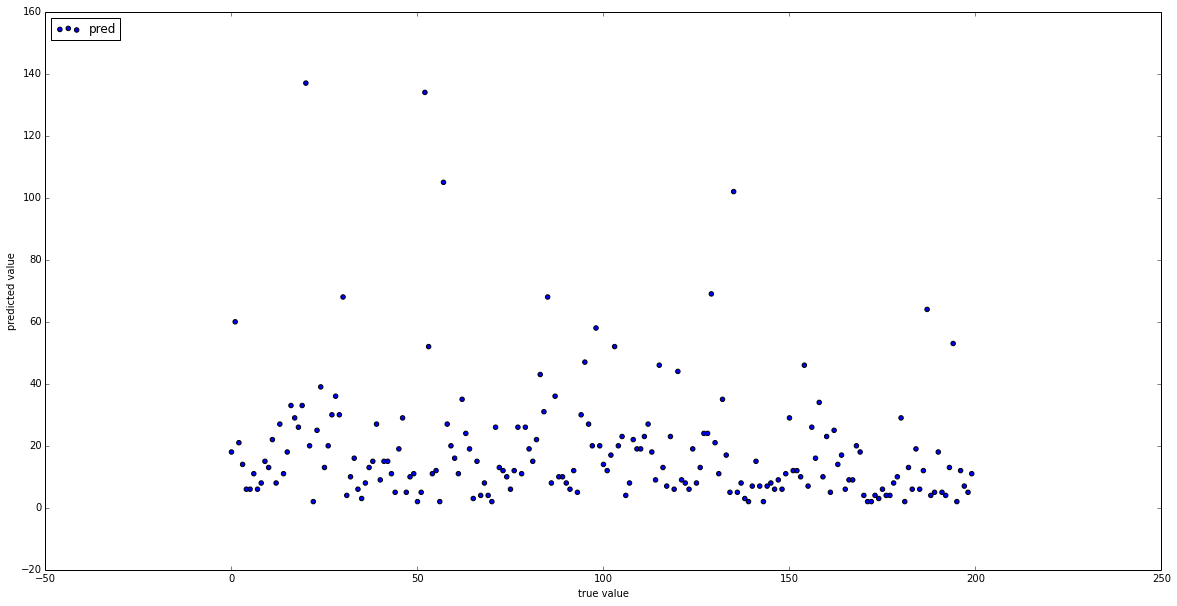

In [50]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
# tmpPre= [ i[1] for i in predicted  ]
# tmpY= [ i[1] for i in y_test  ]

# plt.scatter


plt.scatter(range(len(x[0])), x[0], label = 'pred')
# plt.plot( tmpY, label = 'true' )
plt.xlabel('true value')
plt.ylabel('predicted value')
plt.legend( loc='upper left',fontsize=12 )

plt.show()

# x,y = feature_target_build(seq2seq, dur)

# print x[0]


In [18]:
# target replication

#  network set-up
in_out_neurons = 1
hidden_neurons = 200

# optimizer 
learning_rate = 0.005
decay_rate = learning_rate / 20
momentum = 0.9 # , decay=decay_rate
sgd = SGD(lr=learning_rate, momentum=momentum, nesterov=True)

adam=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

# data preparation parameter
replicate = True
seq2seq = True

x,y = feature_target_build(seq2seq, dur)

# seq2seq==True
if seq2seq==True:
    model = Sequential()
    model.add(LSTM(hidden_neurons, input_dim=in_out_neurons, return_sequences=True, \
               input_length=win_size  ))
    model.add(TimeDistributed(Dense(1)))
    model.add(Activation("linear"))

else:
    print "Problem!"

# training 
model.compile(loss="mean_squared_error", optimizer=adam)
    
(X_train, y_train), (X_test, y_test) = train_test_split(x,y, seq2seq)  # retrieve data

print X_train.shape, y_train.shape

model.fit(X_train, y_train, batch_size=350, nb_epoch=10)
#           validation_split=0.05)
test_phase(X_test, y_test, seq2seq)

# and maybe plot it
# pd.DataFrame(predicted).to_csv("predicted.csv")
# pd.DataFrame(y_test).to_csv("test_data.csv")

36991 251
(15371, 250) (15371, 250)
(13834, 250, 1) (13834, 250, 1)
Epoch 1/10
13834/13834 [==============================] - 489s - loss: 5173.8299   
Epoch 2/10
13834/13834 [==============================] - 470s - loss: 4269.3599   
Epoch 3/10
13834/13834 [==============================] - 456s - loss: 4239.4604   
Epoch 4/10
13834/13834 [==============================] - 457s - loss: 4239.7476   
Epoch 5/10
13834/13834 [==============================] - 459s - loss: 4239.9728   
Epoch 6/10
13834/13834 [==============================] - 471s - loss: 4239.3964   
Epoch 7/10
13834/13834 [==============================] - 476s - loss: 4239.1781   
Epoch 8/10
13834/13834 [==============================] - 472s - loss: 4239.0689   
Epoch 9/10
13834/13834 [==============================] - 467s - loss: 4238.7861   
Epoch 10/10
13834/13834 [==============================] - 467s - loss: 4238.8444   
1537 1537
[52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:21: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:22: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [15]:
# pseudo-attention network 

#  network set-up
in_out_neurons = 1
hidden_neurons = 200

# optimizer 
learning_rate = 0.005
decay_rate = learning_rate / 20
momentum = 0.9 # , decay=decay_rate
sgd = SGD(lr=learning_rate, momentum=momentum, nesterov=True)

adam=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

# data preparation parameter
seq2seq = False
replicate = False

x,y = feature_target_build(seq2seq, dur)

model = Sequential()
model.add(LSTM(hidden_neurons, input_dim=in_out_neurons, return_sequences=True, \
               input_length=win_size  ))

model.add(TimeDistributed(Dense(1)))
model.add( Reshape(  (win_size,) ) )
model.add( Dense(1 ))
model.add(Activation("linear")) 

# training 
model.compile(loss="mean_squared_error", optimizer=adam)
    
(X_train, y_train), (X_test, y_test) = train_test_split(x,y, seq2seq)  # retrieve data

print X_train.shape, y_train.shape

model.fit(X_train, y_train, batch_size=400, nb_epoch=10)
# , validation_split=0.05

test_phase(X_test, y_test, seq2seq)

36991 251
(15588, 250) (15588, 1)
(14029, 250, 1) (14029, 1)
Epoch 1/10
14029/14029 [==============================] - 527s - loss: 5131.0915   
Epoch 2/10
14029/14029 [==============================] - 533s - loss: 4869.6762   
Epoch 3/10
14029/14029 [==============================] - 520s - loss: 4846.2988   
Epoch 4/10
14029/14029 [==============================] - 520s - loss: 4828.9121   
Epoch 5/10
14029/14029 [==============================] - 534s - loss: 4821.1287   
Epoch 6/10
14029/14029 [==============================] - 542s - loss: 4802.3799   
Epoch 7/10
14029/14029 [==============================] - 544s - loss: 4804.2234   
Epoch 8/10
14029/14029 [==============================] - 546s - loss: 4796.2112   
Epoch 9/10
14029/14029 [==============================] - 544s - loss: 4790.3413   
Epoch 10/10
14029/14029 [==============================] - 547s - loss: 4784.0254   
1559 1559
[50, 37, 38, 47, 40, 39, 52, 48, 51, 56, 37, 36, 38, 65, 46, 55, 56, 65, 40, 45, 43, 57,

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:21: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:22: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [35]:
model.summary()

--------------------------------------------------------------------------------
Initial input shape: (None, 300, 1)
--------------------------------------------------------------------------------
Layer (name)                  Output Shape                  Param #             
--------------------------------------------------------------------------------
LSTM (lstm)                   (None, 300, 200)              161600              
TimeDistributed (timedistribut(None, 300, 1)                201                 
Activation (activation)       (None, 300, 1)                0                   
--------------------------------------------------------------------------------
Total params: 161801
--------------------------------------------------------------------------------
